In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import config

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

/home/nadezhda/test/Transformer-Image-Captioning-IIW/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(config)
torch.cuda.empty_cache()

In [3]:
batch_size_train = config.BATCH_SIZE_TRAIN
batch_size_test = config.BATCH_SIZE_TEST

H = config.IMG_HEIGHT
W = config.IMG_WIDTH
P = config.PATCH_SIZE
D_IMG = config.IMG_EMBEDDING_DIM

# The data will get truncated/padded to this length AFTER tokenization
L = config.MAX_TEXT_SEQUENCE_LENGTH
D_TEXT = config.TEXT_EMBEDDING_DIM
DROPOUT_DEC = config.DECODER_DROPOUT_PROB

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(42)

## Build Dataset

In [5]:
data_loader = DatasetLoader(dataset_type=config.DATASET, batch_size_train=batch_size_train, batch_size_test=batch_size_test, shuffle_test=True)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading DOCCI dataset...
DatasetDict({
    train: Dataset({
        features: ['image', 'description'],
        num_rows: 9647
    })
    test: Dataset({
        features: ['image', 'description'],
        num_rows: 5000
    })
    qual_dev: Dataset({
        features: ['image', 'description'],
        num_rows: 100
    })
    qual_test: Dataset({
        features: ['image', 'description'],
        num_rows: 100
    })
})


Number of training samples: 9647
Number of test samples: 5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.2535014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.483

torch.Size([16, 3, 224, 224])
Caption: An indoor, close up, eye level view of the front of a small white cat with dark brown ears crawling out of a square opening cut out in the front of a large silver plastic tub. The cat has its head turned to the right, looking at a green scratching post. The cat is missing its left front leg. A small sticker with "#3" written in black is placed above the opening. A corner of a teal brick wall is behind the plastic tub. A blue plastic square with a circular opening is to the right of the scratching post. A small log is visible on top of the plastic square.
torch.Size([16, 3, 224, 224])
Caption: An outdoor medium view of an over-sized paved chess board with all 16 white pieces and 16 black pieces about 2ft -2. 5ft in height. A white wood chair sits on the right and a black wood chair on the left of the board, with a small grey metal table on the far side. A pebble trail lined by large white stones runs left to right in the background, being partly co

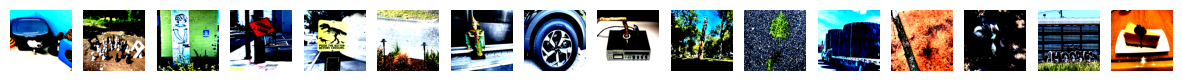

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..0.8004202].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


torch.Size([16, 3, 224, 224])
Caption: An outdoor medium shot of a white horse with light gray speckles facing the left with its head down and eyes closed, as if it's sniffing the brown dirt scattered with white rocks. Its fluffy tail is gradient from white to brown is curled over towards its left hind leg. The shadow falls on the ground towards its left, indicating the sun high and to the right. A red metal fence runs horizontally in the background with small green shrubs visible beneath it and tall green bushy trees behind it. Daytime.
torch.Size([16, 3, 224, 224])
Caption: A close up 3/4's angle of a late model black Honda four door Accord with a blank license plate parked in a Top Golf parking lot. The sun is shining heavily from the right side of the frame. The Honda is casting a large shadow on the left side of the frame. Directly underneath the honda is a section of parking lot that is being hit by the sun. The section of parking lot connects to the curb with a tree bed built in

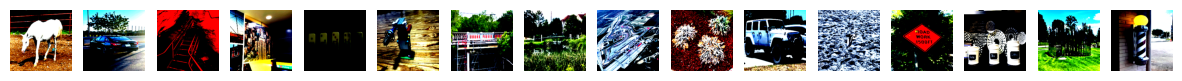

In [6]:
# dataset stats
print(f"Number of training samples: {len(train_dataloader.dataset)}")
print(f"Number of test samples: {len(test_dataloader.dataset)}")

# plot some samples from the dataset
data_iter = iter(test_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_test, figsize=(15, 5))
for i in range(batch_size_test):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

data_iter = iter(train_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_train, figsize=(15, 5))
for i in range(batch_size_train):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

## Initialize Tokenizer

In [7]:
special_tokens = [config.SpecialTokens.PAD, config.SpecialTokens.BOS, config.SpecialTokens.EOS]
if config.TOKENIZER_TYPE == config.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config.TOKENIZER_TYPE == config.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=config.TOKENIZER_DATA_PATH, filename_prefix=config.TOKENIZER_FILENAME_PREFIX)
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}")

Tokenizer vocab size: 14165


## Configure Model

In [8]:
transformer = CPTR(num_patches=config.NUM_PATCHES,
                   img_emb_dim=D_IMG,
                   patch_size=P,
                   text_emb_dim=D_TEXT,
                   d_model=D_TEXT,
                   max_text_seq_len=L,
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   verbose=False).to(device)

Initialized ViT Encoder: google/vit-base-patch16-224-in21k


## Training code

In [9]:
class EarlyStopping:
    def __init__(self, patience=config.EARLY_STOPPING_PATIENCE, delta=config.EARLY_STOPPING_DELTA, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
    
    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print("Stopping early as no improvement has been observed.")

In [10]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch in dataloader:
        images = batch["pixel_values"].to(device)
        texts = batch["description"]

        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids']
        tokens = tokens.to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        attention_mask = get_causal_mask(T, device=device)
        padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)

        logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)


        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to a max norm of 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def train_step_accumulate(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               accumulation_steps: int,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    accumulation_steps: Number of steps to accumulate gradients before updating the model.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    model.train()
    train_loss, train_acc = 0, 0
    
    # Reset gradients at the start
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        images = batch["pixel_values"].to(device)
        texts = batch["description"]
        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids'].to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        
        logits, loss = model(
            images=images, 
            text_tokens=decoder_inputs, 
            attn_mask=get_causal_mask(T, device), 
            pad_mask=get_padding_mask(decoder_inputs, pad_idx, device), 
            targets=targets
        )

        # 3. Normalize loss to account for accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # 4. Optimizer Step (only every 'accumulation_steps')
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad() # Clear for next set

        train_loss += (loss.item() * accumulation_steps)

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              tokenizer,
              pad_idx: int,
              device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    model.eval()

    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        for batch in dataloader:
          images = batch["pixel_values"].to(device)
          texts = batch["description"]

          outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
          tokens = outputs['input_ids']
          tokens = tokens.to(device)
          tokens = tokens.to(device)

          targets = tokens[:, 1:]
          decoder_inputs = tokens[:, :-1]
          T = decoder_inputs.size(1)
          attention_mask = get_causal_mask(T, device=device)
          padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)
        
          logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

          test_loss += loss.item()

          preds = logits.argmax(dim=-1)
          pad_idx = tokenizer.get_padding_token_id()
          non_pad = targets != pad_idx
          acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
          test_acc += acc.item()
          
          if verbose:
            # print produced tokens for debugging
            if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
              decoded_preds = tokenizer.decode_batched(preds)
              decoded_targets = tokenizer.decode_batched(targets)
              for dp, dt in zip(decoded_preds, decoded_targets):
                  print(f"Predicted: {dp} | Target: {dt}")

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_perplexity = torch.exp(torch.tensor(test_loss)).item()
    test_acc = test_acc / len(dataloader)
    return test_loss, test_perplexity, test_acc

def train(model: torch.nn.Module,
          tokenizer, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          device: torch.device,
          early_stop_patience: int,
          early_stop_delta: float) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_perplexity: [...],
              train_acc: [...],
              test_loss: [...],
              test_perplexity: [...],
              test_acc: [...]} 
    """
    results = {"train_loss": [],
               "train_perplexity": [],
               "train_acc": [],
               "test_loss": [],
               "test_perplexity": [],
               "test_acc": []
    }
    
    model.to(device)
    
    pad_idx = tokenizer.get_padding_token_id()
    early_stopping = EarlyStopping(patience=early_stop_patience, delta=early_stop_delta, verbose=True)

    for epoch in tqdm(range(epochs)):
        if config.USE_ACCUMULATED_GRADIENTS:
            train_loss, train_perplexity, train_acc = train_step_accumulate(model=model,
                                              dataloader=train_dataloader,
                                              tokenizer=tokenizer,
                                              pad_idx=pad_idx,
                                              optimizer=optimizer,
                                              scheduler=scheduler,
                                              accumulation_steps=config.ACCUMULATION_STEPS,
                                              device=device,
                                              epoch=epoch)
        else:
          train_loss, train_perplexity, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            tokenizer=tokenizer,
                                            pad_idx=pad_idx,
                                            optimizer=optimizer,
                                            scheduler=scheduler,
                                            device=device,
                                            epoch=epoch)
        test_loss, test_perplexity, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          tokenizer=tokenizer,
          pad_idx=pad_idx,
          device=device,
          epoch=epoch)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_perplexity: {train_perplexity:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_perplexity: {test_perplexity:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_perplexity"].append(train_perplexity)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_perplexity"].append(test_perplexity)
        results["test_acc"].append(test_acc)

        early_stopping.check_early_stop(test_loss)
        if early_stopping.stop_training:
            break
    
    return results

In [11]:
# freeze encoder weights
def config_encoder_params(model, requires_grad: bool):
    if config.ENCODER_ARCH == config.EncoderArch.CNN_RESNET50:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad
    elif config.ENCODER_ARCH == config.EncoderArch.VIT_STYLE_BASE or config.ENCODER_ARCH == config.EncoderArch.VIT_STYLE_LARGE:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad
    elif config.ENCODER_ARCH == config.EncoderArch.CNN_CPTR_STYLE:
        for param in model.encoder.feature_extractor.parameters():
            param.requires_grad = requires_grad

In [12]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=config.LABEL_SMOOTHING) # ignore the padding token for loss calculation

if config.NUM_FREEZE_EPOCHS > 0:
    config_encoder_params(transformer, requires_grad=False)
    
    optimizer = torch.optim.AdamW(
        [p for p in transformer.parameters() if p.requires_grad],
        lr=config.LR,
        weight_decay=0.01
    )
    
    if config.USE_ACCUMULATED_GRADIENTS:
        effective_steps_per_epoch = len(train_dataloader) // config.ACCUMULATION_STEPS
        # Account for the possible partial batch at the end
        if len(train_dataloader) % config.ACCUMULATION_STEPS != 0:
            effective_steps_per_epoch += 1
    else:
        effective_steps_per_epoch = len(train_dataloader)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config.LR, 
        steps_per_epoch=effective_steps_per_epoch, 
        epochs=config.NUM_FREEZE_EPOCHS,
        pct_start=0.1 # 10% of time spent warming up
    )

In [13]:
# Check which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
decoder.word_embedding.embedding.weight: torch.Size([14165, 768])
decoder.text_layernorm.weight: torch.Size([768])
decoder.text_layernorm.bias: torch.Size([768])
decoder.decoder_blocks.0.MMHSA.in_proj_weight: torch.Size([2304, 768])
decoder.decoder_blocks.0.MMHSA.out_proj.weight: torch.Size([768, 768])
decoder.decoder_blocks.0.layer_norm_1.weight: torch.Size([768])
decoder.decoder_blocks.0.layer_norm_1.bias: torch.Size([768])
decoder.decoder_blocks.0.MHCA.in_proj_weight: torch.Size([2304, 768])
decoder.decoder_blocks.0.MHCA.out_proj.weight: torch.Size([768, 768])
decoder.decoder_blocks.0.layer_norm_2.weight: torch.Size([768])
decoder.decoder_blocks.0.layer_norm_2.bias: torch.Size([768])
decoder.decoder_blocks.0.FFN.0.weight: torch.Size([3072, 768])
decoder.decoder_blocks.0.FFN.3.weight: torch.Size([768, 3072])
decoder.decoder_blocks.0.layer_norm_3.weight: torch.Size([768])
decoder.decoder_blocks.0.layer_norm_3.bias: torch.Size([768])
decoder.decoder_bloc

In [ ]:
if config.NUM_FREEZE_EPOCHS > 0:
    # Train the model for freezing phase
    results = train(model=transformer,
                    tokenizer=tokenizer,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    epochs=config.NUM_FREEZE_EPOCHS,
                    device=device,
                    early_stop_patience=config.EARLY_STOPPING_PATIENCE,
                    early_stop_delta=config.EARLY_STOPPING_DELTA)
    print('Completed freezing phase.')

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
config_encoder_params(transformer, requires_grad=True)

optimizer = torch.optim.AdamW(
    [
        {
            'params': [p for n, p in transformer.named_parameters() if "encoder" not in n],
            'lr': config.LR
        },
        {
            'params': [p for n, p in transformer.named_parameters() if "encoder" in n],
            'lr': config.LR * 0.01
        }
    ],
    weight_decay=config.WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.NUM_EPOCHS,
    eta_min=1e-7
)

In [ ]:
# Recheck which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
encoder.vit.embeddings.cls_token: torch.Size([1, 1, 768])
encoder.vit.embeddings.position_embeddings: torch.Size([1, 197, 768])
encoder.vit.embeddings.patch_embeddings.projection.weight: torch.Size([768, 3, 16, 16])
encoder.vit.embeddings.patch_embeddings.projection.bias: torch.Size([768])
encoder.vit.encoder.layer.0.attention.attention.query.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.0.attention.attention.query.bias: torch.Size([768])
encoder.vit.encoder.layer.0.attention.attention.key.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.0.attention.attention.key.bias: torch.Size([768])
encoder.vit.encoder.layer.0.attention.attention.value.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.0.attention.attention.value.bias: torch.Size([768])
encoder.vit.encoder.layer.0.attention.output.dense.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.0.attention.output.dense.bias: torch.Size([768])
encoder.vit.encoder.layer.0.interme

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Train the model for the rest of the epochs and save the training results to a dictionary
results = train(model=transformer,
                tokenizer=tokenizer,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                epochs=config.NUM_EPOCHS,
                device=device,
                early_stop_patience=config.EARLY_STOPPING_PATIENCE,
                early_stop_delta=config.EARLY_STOPPING_DELTA)
print('Completed training.')

  0%|          | 0/1 [03:46<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# export training results to results directory
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
results_path = os.path.join(results_dir, 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f)

time_string = time.strftime("%Y%m%d-%H%M%S")
# export model weights
model_path = os.path.join(results_dir, f'cptr_model_{time_string}.pth')
torch.save(transformer.state_dict(), model_path)

## Test caption generation

In [ ]:
transformer = CPTR(num_patches=config.NUM_PATCHES,
                   img_emb_dim=D_IMG,
                   patch_size=P,
                   text_emb_dim=D_TEXT,
                   d_model=D_TEXT,
                   max_text_seq_len=L,
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   verbose=False).to(device)
transformer.load_state_dict(torch.load(model_path, map_location=device))

Initialized ViT Encoder: google/vit-base-patch16-224-in21k


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9876702..2.6051416].


Caption GT:  A close up overhead view of a building drawn onto a navy blue concrete court with white chalk. The building has double doors and six windows. A stray chalk streak is drawn to the left of the building and is going toward the left of the image. The left side of the building is slightly pushed in towards the right. The chalk building is on top of a white line that is printed onto the court. Another white line is on the left side of the image. A crack in the concrete is running from the bottom left of the image to the upper right. Another crack is intersecting the first crack, and is running from the right of the image to the left.
Input image shape: torch.Size([1, 3, 224, 224])


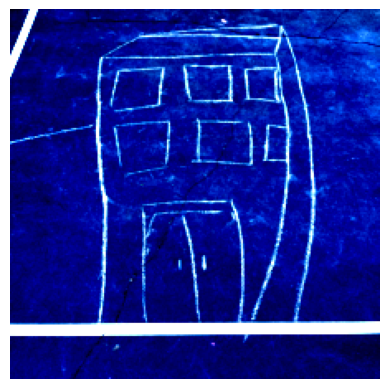

Generated token ids: tensor([   1,   68,   35,  293,  113,  106,  577,  336,  269,  261, 1113,  308,
         746,  431,  118,  285,  261, 1113,  264,  113,  262,  522,  345,  313,
         418,   49,  294,  266,  261,  266,  746,  978,  480,  118,  264,  113,
         262,  461,  269,  262,  458,   47,  285,  261,  259,  310,  431,  308,
         746,  271,  268,  103,  462,  292,  262,  318,  339,   49,  294,  383,
         286,  270,  117,  431,  118,  261,  266,  264,  113,  262,  461,   47,
         685,  303,  275,  331,  102,  310,  124,   47,  285,  261, 4837,  269,
         262,  263,  119,  260,  117,  431,  118,  261,  266,  264,  113,  262,
         461,   47,  685,  303,  275,  331,  102,  310,  124,   49,  294,  266,
         261,  266,  746,  978,  480,  118,  264,  113,  262,  461,   47,  285,
         261, 4837,  269,  262,  263,  119,  260,  117,  431,  118,  261,  266,
         264,  113,  262,  461,   47,  685,  303,  275,  331,  102,  310,  124,
          49,  294,

In [ ]:
transformer.eval()

batch = next(iter(test_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu().permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[config.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[config.SpecialTokens.EOS.value],
        max_len=L,
        device=device)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
print('Generated token ids:', tokens)
print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('Generated caption:', decoded_caption)